In [175]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime
import torch

In [176]:
def setSeeds(seed = 42):
    # 랜덤 시드를 설정하여 매 코드를 실행할 때마다 동일한 결과를 얻게 합니다.
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
setSeeds(42)

In [177]:
def feature_split_user(df):
    new_df = df.copy()
    new_df["newUserID"] = df['assessmentItemID'].apply(lambda x:x[:3]) + df['userID'].astype(str)
    return new_df

def get_remain_test_data(df_test):
    get_new_id = set(df_test.loc[df_test.answerCode == -1, 'newUserID'])    
    test_data = df_test[df_test.newUserID.isin(get_new_id)]
    remain_data = df_test.drop(test_data.index)
    return test_data, remain_data

In [178]:
train_path = '/opt/ml/input/data/train_dataset/train_data.csv'
test_path = '/opt/ml/input/data/train_dataset/test_data.csv'

df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

df_train = feature_split_user(df_train_ori)
df_test = feature_split_user(df_test_ori)

df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것
df_test, remain_data = get_remain_test_data(df_test)
df_train = pd.concat([df_train, remain_data])

df_train_test = pd.concat([df_train, df_test['answerCode'], df_test[df_test['answerCode'] != -1]])

In [179]:
# trian에서 각 문제 평균 뽑기
testId_mean_sum = df_train_test.groupby(['testId'])['answerCode'].agg(['mean','sum']).to_dict()
assessmentItemID_mean_sum = df_train_test.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum']).to_dict()
KnowledgeTag_mean_sum = df_train_test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum']).to_dict()

In [180]:
# new user id 겹치는거 없음 확인
s1 = set(df_test.loc[:, 'newUserID'])
s2 = set(df_train.loc[:, 'newUserID'])
s1 & s2

set()

## Feature engineering
### 한번만 실행되도록 설정

In [181]:
def feature_engineering(df_ori):
    df = df_ori.copy()
    def assessmentItemID2item(x):
        return int(x[-3:]) - 1
    df['item'] = df.assessmentItemID.map(assessmentItemID2item)
    # testId별로 나오는 문제 갯수
    item_size = df[['assessmentItemID', 'testId']].drop_duplicates().groupby('testId').size()
    testId2maxlen = item_size.to_dict() # 중복해서 풀이할 놈들을 제거하기 위해
    
    item_max = df.groupby('testId')['item'].max()

    # 순서대로 풀지 않은 문제의 index
    not_order_index = item_max[item_max +1 != item_size].index    
    not_order_test = df.loc[df.testId.isin(not_order_index)][['assessmentItemID','testId']].drop_duplicates().sort_values('assessmentItemID')
    not_order_group = not_order_test.groupby('testId')

    not_order_ID2item = {}
    for key in not_order_group.groups:
        for i, (k, _) in enumerate(not_order_group.get_group(key).values):
            not_order_ID2item[k] = i
    
    def assessmentItemID2item_order(x):
        if x in not_order_ID2item:
            return int(not_order_ID2item[x])
        return int(x[-3:]) -1
    df['orded_item'] = df.assessmentItemID.map(assessmentItemID2item_order)
    df_group = df.groupby(['newUserID','testId'])['answerCode']
    df['user_correct_answer'] = df_group.transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df_group.cumcount()
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    
    df["test_mean"] = df.testId.map(testId_mean_sum['mean'])
    df["ItemID_mean"] = df.assessmentItemID.map(assessmentItemID_mean_sum['mean'])
    df["tag_mean"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['mean'])
    return df

In [182]:
if os.path.exists("fe_train.csv") and os.path.exists("fe_test.csv"):
    FE_train = pd.read_csv("fe_train.csv")
    FE_test = pd.read_csv("fe_test.csv")
    FE_train.drop('Unnamed: 0', axis=1, inplace=True)
    FE_test.drop('Unnamed: 0', axis=1, inplace=True)
    print("cache dataset complete")
else:
    print("working on feature engineering.")
    FE_train = feature_engineering(df_train)
    FE_test = feature_engineering(df_test)
    FE_train.to_csv('fe_train.csv')
    FE_test.to_csv('fe_test.csv')
    print("save dataset")

cache dataset complete


## catergorical data preprocessing

In [183]:
a = set(FE_train.assessmentItemID)
b = set(FE_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.testId)
b = set(FE_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.KnowledgeTag)
b = set(FE_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.newUserID)
b = set(FE_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [199]:
from sklearn.preprocessing import LabelEncoder
# test data와 train data를 함께 handling하기 때문에 이전과 이후의 차이가 있는지 확인
def categori_preprocessing(PP_train, PP_test):
    cate_cols = ['newUserID', 'assessmentItemID', 'testId', 'KnowledgeTag']  # 문항, 시험지, 문항 태그
    PP_full = pd.concat([PP_train, PP_test])
    
    print("처리 시작")
    for col in cate_cols:
        label_encoder = LabelEncoder()
        #For UNKNOWN class
        a = PP_full[col].unique().tolist() + ['unknown']
        label_encoder.fit(a)

        #모든 컬럼이 범주형이라고 가정
        PP_full[col] = PP_full[col].astype(str)
        test = label_encoder.transform(PP_full[col])
        PP_full[col] = test
        PP_full[col] = PP_full[col].astype('category')
        print(col + "처리")
        
    return PP_full[:len(PP_train)], PP_full[len(PP_train):]

PP_train, PP_test = categori_preprocessing(FE_train, FE_test)

처리 시작
newUserID처리
assessmentItemID처리
testId처리
KnowledgeTag처리


In [200]:
a = set(PP_train.assessmentItemID)
b = set(PP_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.testId)
b = set(PP_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.KnowledgeTag)
b = set(PP_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.newUserID)
b = set(PP_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [201]:
# 문제 없다면 다시 train test로 분배!
df_train, df_test = PP_train, PP_test

# validation split

In [202]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test.loc[df_test.answerCode == -1, 'assessmentItemID'].values) # 문제별 ID
set_testId = set(df_test.loc[df_test.answerCode == -1, 'testId'].values) # 시험지별 ID
set_tag = set(df_test.loc[df_test.answerCode == -1, 'KnowledgeTag'].values) # 시험지별 ID

In [203]:
def get_full_valid_split(df_ori, filter_option=None):
    random.seed(0)
    df = df_ori.copy()
    df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]
    val_newUserId = set(df_val.newUserID.values)

    if filter_option == "test":
        df_train = df[df['testId'] != df['testId'].shift(-1)]
    elif filter_option == "user":
        df_train = df[df['newUserID'] != df['newUserID'].shift(-1)]
    else:
        df_train = df
    return df_train, df_val

In [204]:
df_train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'newUserID', 'item', 'orded_item',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'test_mean',
       'ItemID_mean', 'tag_mean'],
      dtype='object')

In [208]:
filter_option = 'test' #user, none

FEATS = ['ItemID_mean', 'user_acc', 'test_mean', 'tag_mean', 'assessmentItemID']
categorical_features = ['assessmentItemID'] # KnowledgeTag, newUserID, testId, assessmentItemID
numeric_features = []
FEATS = FEATS + categorical_features + numeric_features
df_train, df_val = get_full_valid_split(df_train, filter_option) # test filter 기준 398628 , 35404 rows면 잘 분배된거에요
print(len(df_train))
print(len(df_val))

398628
35402


# dataset 구성 & Train

In [209]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train_answer = df_train['answerCode']
train = df_train.drop(['answerCode'], axis=1)

test_answer = df_val['answerCode']
test = df_val.drop(['answerCode'], axis=1)

lgb_train = lgb.Dataset(train[FEATS], train_answer, free_raw_data=False)
lgb_test = lgb.Dataset(test[FEATS], test_answer, free_raw_data=False)

[LightGBM] [Info] Number of positive: 223634, number of negative: 174994
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3655
[LightGBM] [Info] Number of data points in the train set: 398628, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561009 -> initscore=0.245259
[LightGBM] [Info] Start training from score 0.245259
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.500378	valid_1's binary_logloss: 0.512938
[200]	training's binary_logloss: 0.499047	valid_1's binary_logloss: 0.51222
[300]	training's binary_logloss: 0.498294	valid_1's binary_logloss: 0.511792
[400]	training's binary_logloss: 0.497656	valid_1's binary_logloss: 0.511429
[500]	training's binary_logloss: 0.49709	valid_1's binary_logloss: 0.5

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

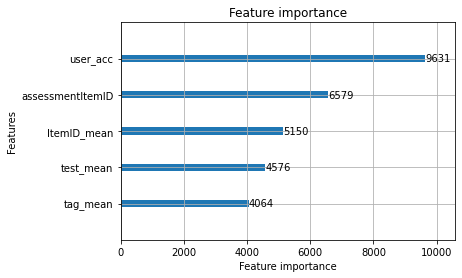

In [210]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    categorical_feature=categorical_features
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(test_answer, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(test_answer, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
lgb.plot_importance(model)

# inference

In [211]:
# MAKE PREDICTION
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것

total_preds = model.predict(df_test_shift[FEATS])
# SAVE OUTPUT
output_dir = './'
prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : ./0607_2349.csv
